In [1]:
'''
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
© Copyright IBM Corp. 2019 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
'''

'\nLicensed Materials - Property of IBM\nIBM Maximo APM - Predictive Maintenance Insights On-Premises\nIBM Maximo APM - Predictive Maintenance Insights SaaS \n© Copyright IBM Corp. 2019 All Rights Reserved.\nUS Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.\n'

# Maximo APM PMI - Anomaly Detection Model Template

1. [Introduction](#introduction)
2. [Install Maximo APM PMI SDK](#install-maximo-apm-pmi-sdk)
3. [Setup the Model Training Pipeline](#setup-model-training-pipline)
4. [Train the Model Instance](#train-model-instance)
5. [Register the Trained Model Instance](#register-trained-model-instance)
6. [Model Template Internals](#model-template-internals)

<a id='introduction'></a>
## Introduction

IoT sensors are pervasive in the manufacturing industries for monitoring assets. The data these sensors capture can be combined with advanced statistical and machine learning algorithms to yield insight on pending failures and optimal maintenance and operation strategies. A gas turbine, compressor, and boat engine are examples of valuable and costly assets that can benefit from such insights. These industrial assets fail due to many reasons, and often they behave in abnormal ways preceding the behaviour. In order to have an effective predictive maintenance program, it is crucial to be able to detect these abnormalities so that action can be taken before costly downtimes occur due to unexpected failures. However, identifying these tell-tale abnormalities before a failure event is difficult since, in general, failures are comparatively rare events so there is often a scarcity of tagged data for building predictive models. In the absence of abundant tagged (supervised) failure data, anomaly detection techniques as described in this notebook provide an unsupervised way of learning a model from data that mostly contains “normal” operating data with a sparse number of actual failure events.

Maximo APM PMI automated anomaly learning framework (see the following figure) explores various anomaly detection techniques to identify an optimal one. The anomaly framework is divided into an anomaly trainer and anomaly evaluator: The anomaly model is first learned on the training data that is assumed to be “normal” by anomaly trainer. In the following example figure, we plot two failures observed for an asset over a time. The normal data are selected from a time window that is far from the time were the failure occurred (i.e., the asset is operating normally). The trained model is applied on the validation data (mostly data coming from the pre-failure window in case of time series data) to obtain the anomaly validator. In anomaly validator, we calculate the performance of each anomaly model with respect to the anomaly label, where samples very near the failures are assigned anomaly label 1 (see 0 and 1 in pre-failure window). In summary, a user must provide two datasets for anomaly learning:

1. Normal Data to train the anomaly model. All samples are from one class only (i.e., class 0)
2. Validation Data to do anomaly scoring and evaluation. Samples are from pre-failure windows with samples close to failures are labelled as a class 

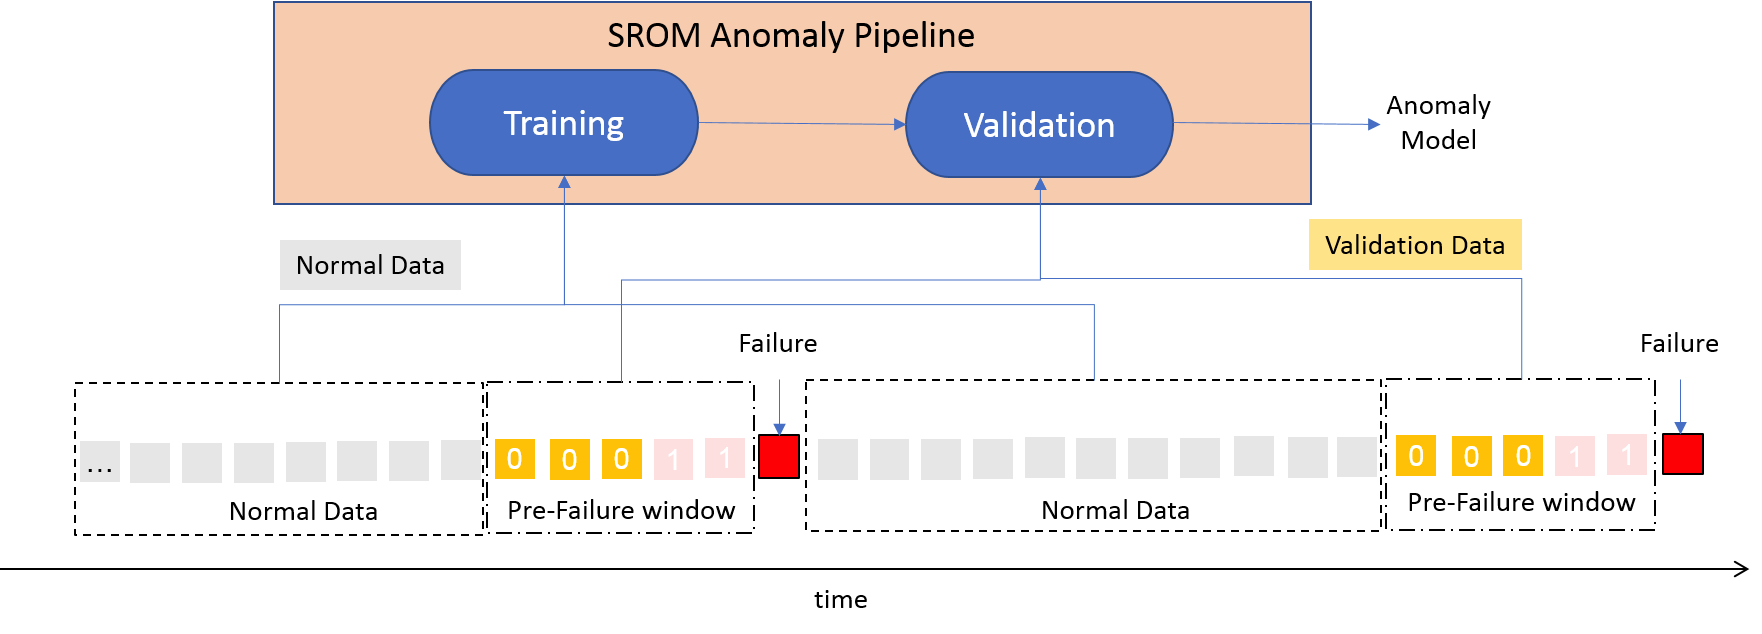

<a id="install-maximo-apm-pmi-sdk"></a>
## Install Maximo APM PMI SDK

To install the SDK, you need your Maximo APM PMI instance ID, API base URL, and your API key. The Maximo APM PMI instance ID and API base URL can be found in the user welcome letter. For API key, request to your Maximo admin to create an user account first to generate one for you. Create one environment variable for each here.

In [2]:
%%capture
%env APM_ID=4ac3917e
%env APM_API_BASEURL=https://prod.pmi.apm.maximo.ibm.com
%env APM_API_KEY=dp7opk78635sbf809f07o4t53lum3c9eoaovpk9f

Then, install PMI SDK with `pip`. Note that we have to upgrade `pip` first.

In [3]:
!pip install -U pip~=18.1
!pip install pyspark
!pip install -U https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/4ac3917e/dp7opk78635sbf809f07o4t53lum3c9eoaovpk9f/lib/download?filename=pmlib-1.0.0.tar.gz

Requirement already up-to-date: pip~=18.1 in /opt/conda/envs/Python36/lib/python3.6/site-packages (18.1)
    100% |████████████████████████████████| 798kB 56.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for pmlib ... done
  Stored in directory: /home/dsxuser/.tmp/pip-ephem-wheel-cache-apzc75y4/wheels/27/e3/4f/8f4f27f0744ea9362917922e6990c31fc7ed89833aa12f6e3a
Successfully built pmlib
  Found existing installation: pmlib 1.0.0
    Uninstalling pmlib-1.0.0:
      Successfully uninstalled pmlib-1.0.0


<a id="setup-model-training-pipline"></a>
## Setup the Model Training Pipeline

Before you can start working on the model training pipeline, you have to setup an asset group and asset-sensor relationshp properly in Maximo. See IBM Maximo APM - Predictive Maintenance Insights SaaS User Guide for details.

Required model pipeline configuration:

* Asset group ID: The unit of model processing is an asset group. Asset groups are managed on Maximo APM UI. You need to get the ID of the asset group to be analyzed by this model.
* Sensor data as features: This model also accepts one or more features from either asset data or IOT data. **Note that these features must be of numeric type.** Features are specifed simply by attribute names prefixed by type (with separator colon). For asset attribute, the prefix is an empty string. For IOT data attribute, the prefix is the device type registered on Watson IOT Platform.
* Prediction output names: This model generates two outputs, the calculated anomaly score and the anomaly threshold. Give them names (containing only alphanumeric, dash, and underline). **Note that the order of the two names matters, the first must be the calculated anomaly score.**
* SROM training options: This model requires much higher computation compared to the other out of box models, hence it usually takes very long to complete the training on Watson Studio. It might be necessary to use Python with Spark environment (with 10 executors) on Watson Studio to increase the training speed. You can specify either **``"exectype": "spark_node_random_search"```** or **```"exectype": "spark_node_complete_search"```** to enable this.

Optionally, you can also provide asset failure history (Asset Workorder attribute **```faildate```** in Maximo) as validation data to further improve the trained model.

Now you can setup a training pipeine based on this model template, with your own data, to train a model instance.

In [4]:
from pmlib.anomaly_detection import AnomalyDetectionAssetGroupPipeline

group = AnomalyDetectionAssetGroupPipeline(
            asset_group_id='1016', 
            model_pipeline={
                "features": ["IIOT:flow", "IIOT:energy", "IIOT:vibration"],
                "features_for_training": [":faildate"],
                "predictions": ["anomaly_score", "anomaly_threshold"],
                "srom_training_options": {
                    "exectype": "spark_node_random_search" # spark_node_random_search or spark_node_complete_search
                }
            })

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GraphLasso is deprecated; The 'GraphLasso' was renamed to 'GraphicalLasso' in version 0.20 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)


2020-03-30T09:33:31.701 pmlib.api.init_environ INFO APM_ID=4ac3917e, APM_API_BASEURL=https://prod.pmi.apm.maximo.ibm.com, APM_API_KEY=********
2020-03-30T09:33:31.702 pmlib.util.api_request INFO method=get, url=https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/tenant?instanceId=4ac3917e, headers={'apmapitoken': '********'}, timeout=30, ssl_verify=True, json=None, session=None, kwargs={}
2020-03-30T09:33:33.501 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/tenant?instanceId=4ac3917e
2020-03-30T09:33:33.511 pmlib.api.init_environ DEBUG resp={
    "as_apikey": "********",
    "as_apitoken": "********",
    "as_id": null,
    "as_url": "https://api-us.connectedproducts.internetofthings.ibmcloud.com",
    "info": {
        "API_BASEURL": "https://api-us.connectedproducts.internetofthings.ibmcloud.com",
        "API_KEY": "********",
        "API_TOKEN": "********",
        "COS_BUCKET_KPI": "analytics-

The example above configured a pipeline for this model, accepting **```x1```** through **```x42```** of Watson IOT Platform device type **```SampleAnomalySensor```**. It also uses asset attribute **```faildate```** to extract the labels for training. The predicted output of the trained model instance is called **```anomaly_score```** (for calculated anomaly score) and **```anomaly_threshold```** (for anomaly threshold).

By default, this model also generated daily aggregated prediction result taking output names in the form of **```daily_<anomaly_score_output_name>```**.

<a id="train-model-instance"></a>
## Train the Model Instance

Now you can train the model instance.

In [5]:
df = group.execute()

2020-03-30T09:33:39.909 analytics_service.pmlib.cache_loader.AssetCacheRefresher.execute INFO start_ts=None, end_ts=None, entities=None
2020-03-30T09:33:45.529 pmlib.util.api_request INFO method=get, url=https://api-us.connectedproducts.internetofthings.ibmcloud.com/api/meta/v1/CTP-PMI-Democore-31/entityType/ASSET_CACHE, headers={'Content-Type': 'application/json', 'X-api-key': '********', 'X-api-token': '********', 'Cache-Control': 'no-cache'}, timeout=30, ssl_verify=True, json=None, session=None, kwargs={}
2020-03-30T09:33:46.195 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://api-us.connectedproducts.internetofthings.ibmcloud.com/api/meta/v1/CTP-PMI-Democore-31/entityType/ASSET_CACHE
2020-03-30T09:33:46.196 iotfunctions.metadata.__init__ DEBUG Initializing new entity type using iotfunctions 2.0.3
2020-03-30T09:33:46.211 iotfunctions.util.__init__ DEBUG Starting trace
2020-03-30T09:33:46.212 iotfunctions.util.__init__ DEBUG Trace name: auto_trace_ASSET_CACHE

Once this method completes successfully, you'll have a trained model instance reday (for next step, see below) and also with the prediction results returned as a dataframe for verification.

<a id="register-trained-model-instance"></a>
## Register the Trained Model Instance

If the trained model instance looks good, you can register it to Maximo APM PMI:

In [6]:
group.register(write_initial_result=False)

2020-03-30T09:58:54.756 analytics_service.pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.register DEBUG target_pipeilne_class=pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline, url=None
2020-03-30T09:58:54.757 analytics_service.pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline.register DEBUG catalog_config={'name': 'AnomalyDetectionAssetGroupPipeline', 'description': 'AnomalyDetectionAssetGroupPipeline', 'moduleAndTargetName': 'pmlib.anomaly_detection.AnomalyDetectionAssetGroupPipeline', 'url': 'https://prod.pmi.apm.maximo.ibm.com/ibm/pmi/service/rest/ds/4ac3917e/dp7opk78635sbf809f07o4t53lum3c9eoaovpk9f/lib/download?filename=pmlib-1.0.0.tar.gz', 'category': 'TRANSFORMER', 'tags': [], 'output': [{'name': 'names', 'description': 'Provide a list of output names to be generated from the pipeline.', 'dataType': 'ARRAY', 'jsonSchema': {'minItems': 1, '$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'array', 'items': {'type': 'string'}}, 'tags': []}]

'5670F4CD-E5B2-4F53-82CB-A4DF24BD73BC'

Once registration succeeds, you can see this newly trained model instance available for the asset group on IBM Maximo APM - AHI.

<a id="model-template-internals"></a>
## Model Template Internals

The code here is only for illustration purpose.

Maximo APM PMI automated anomaly learning framework use extensive set of anomaly detection methods as well as score computation techniques. In general, Anomaly is a situation where

1. The distribution of underlying data change drastically (Box Plot), and/or
2. The relationship between variables are different under varying conditions (Correlation Matrix).

The Co-variance matrix based anomaly learning methods use covariance matrix and its inverse (a.k.a. precision matrix) to capture the important relationship observed in the training data. Whereas, Density or rule based learner fit the model on training data and try to identify the rough boundary of the normal data. Maximo APM PMI - Anomaly Detection model template is capable to support both the options, i.e., Density or rule based anomaly learner as well as co-variance structure based anomaly learning. Once the model is prepared, it can be used to generate score either for each variable or combined. Calculating score for each feature is an interesting features as many time decision are mostly driven by behaviour of single variable.

In the following cell, we show the source of Maximo APM PMI - Anomaly Detection model template.

In [ ]:
class AnomalyDetectionEstimator(SromEstimator):
    def __init__(self, features, targets, predictions, **kwargs):
        super().__init__(features=features, targets=targets, predictions=predictions, **kwargs)
        self.anomaly_threshold = self.predictions[1]

    def create_pipeline(self):
        from srom.pipeline import AnomalyPipeline
        return AnomalyPipeline()

    def get_stages(self):
        from sklearn.covariance import (EmpiricalCovariance, EllipticEnvelope, LedoitWolf, MinCovDet, OAS, ShrunkCovariance)
        from sklearn.ensemble import IsolationForest
        from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
        from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
        from sklearn.svm import OneClassSVM

        from srom.anomaly_detection.algorithms import NearestNeighborAnomalyModel, LOFNearestNeighborAnomalyModel
        from srom.anomaly_detection.algorithms.srom_pca_Q import AnomalyPCA_Q
        from srom.anomaly_detection.algorithms.srom_pca_T2 import AnomalyPCA_T2
        from srom.anomaly_detection.gaussian_graphical_anomaly_model import GaussianGraphicalModel
        from srom.anomaly_detection.generalized_anomaly_model import GeneralizedAnomalyModel
        from srom.utils.no_op import NoOp

        return [
            [
                ('skipscaling', NoOp()), 
                ('standardscaler', StandardScaler()),
                ('robustscaler', RobustScaler()), 
                ('minmaxscaling', MinMaxScaler())
            ],
            [
                # Rule/Density based Anomaly Models
                ('isolationforest', GeneralizedAnomalyModel(base_learner=IsolationForest(), predict_function='decision_function', score_sign=-1)), 
                ('gaussianmixture', GeneralizedAnomalyModel(base_learner=GaussianMixture(), predict_function='score_samples', score_sign=1)),
                ('bayesiangaussianmixture', GeneralizedAnomalyModel(base_learner=BayesianGaussianMixture(), predict_function='score_samples', score_sign=1)), 
                ('oneclasssvm', GeneralizedAnomalyModel(base_learner=OneClassSVM(), predict_function='decision_function', score_sign=1)), 
                ('nearestneighboranomalymodel', GeneralizedAnomalyModel(base_learner=NearestNeighborAnomalyModel(), predict_function='predict', score_sign=1)), 
                ('lofnearestneighboranomalymodel', GeneralizedAnomalyModel(base_learner=LOFNearestNeighborAnomalyModel(), predict_function='predict', score_sign=1)),
                ('anomalypca_t2', GeneralizedAnomalyModel(base_learner=AnomalyPCA_T2(), predict_function='anomaly_score',score_sign=1)), 
                ('anomalypca_q', GeneralizedAnomalyModel(base_learner=AnomalyPCA_Q(), predict_function='anomaly_score',score_sign=1)),

                # Covariance Structure based Anomaly Models
                ('empiricalcovariance', GeneralizedAnomalyModel(base_learner=EmpiricalCovariance(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('ellipticenvelope', GeneralizedAnomalyModel(base_learner=EllipticEnvelope(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
                ('ledoitwolf', GeneralizedAnomalyModel(base_learner=LedoitWolf(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('mincovdet', GeneralizedAnomalyModel(base_learner=MinCovDet(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('oas', GeneralizedAnomalyModel(base_learner=OAS(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('shrunkcovariance', GeneralizedAnomalyModel(base_learner=ShrunkCovariance(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),

                # GaussianGraphicalModel
                ('ggm_default', GaussianGraphicalModel()), 
                ('ggm_stochastic', GaussianGraphicalModel(distance_metric='Stochastic_Nearest_Neighbors')),
                ('ggm_kldiverse', GaussianGraphicalModel(distance_metric='KL_Divergence_Dist')), 
                ('ggm_frobenius', GaussianGraphicalModel(distance_metric='Frobenius_Norm')),
                ('ggm_likelihood', GaussianGraphicalModel(distance_metric='Likelihood')), 
                ('ggm_spectral', GaussianGraphicalModel(distance_metric='Spectral')),
                ('ggm_mahalanobis_distance', GaussianGraphicalModel(distance_metric='Mahalanobis_Distance')),
                ('ggm_sparsest_k_subgraph', GaussianGraphicalModel(distance_metric='Sparsest_k_Subgraph'))
            ]
        ]

    def get_param_grid(self):
        from srom.pipeline import SROMParamGrid
        return SROMParamGrid(gridtype='anomaly_detection_fine_grid')

    def get_prediction_result_value_index(self):
        return (1, 0)

    def process_prediction_result(self, df, prediction_result, model):
        super().process_prediction_result(df, prediction_result, model)

        if prediction_result is not None:
            self.logger.debug('best_thresholds=%s' % str(model.get_best_thresholds()))
            df[self.anomaly_threshold] = model.get_best_thresholds()[0]
        else:
            df[self.anomaly_threshold] = None

        return df


class AnomalyDetectionAssetGroupPipeline(AssetGroupPipeline):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.model_template_name = 'Anomaly Detection'

        # exclude labels from normal fillna logic
        if self.fillna_exclude is None:
            self.fillna_exclude = []
        if self.pipeline_config.features_for_training is not None:
            self.fillna_exclude.extend(self.pipeline_config.features_for_training)
            self.fillna_exclude = list(set(self.fillna_exclude))

        if self.dropna_exclude is None:
            self.dropna_exclude = []
        if self.pipeline_config.features_for_training is not None:
            self.dropna_exclude.extend(self.pipeline_config.features_for_training)
            self.dropna_exclude = list(set(self.dropna_exclude))

        # no dropna
        self.dropna = None

        # default aggregation post-processing
        prediction = self.pipeline_config.predictions[0]
        default_post_processing = [
            {
                "functionName": "Maximum",
                "enabled": True,
                "granularity": "Daily",
                "output": {
                    "name": "daily_%s" % prediction
                },
                "input": {
                    "source": prediction
                }
            }
        ]
        if self.post_processing is None:
            self.post_processing = default_post_processing
        else:
            for agg in default_post_processing:
                if agg not in self.post_processing:
                    self.post_processing.append(agg)

    def prepare_execute(self, pipeline, model_config):
        estimator = AnomalyDetectionEstimator(**model_config)
        estimator.add_training_preprocessor(TransformNotNaToEvent(model_config.features_for_training[0]))
        estimator.add_training_preprocessor(IdentifyPreFailureWindow(model_config.features_for_training[0], pre_failure_window_size=model_config.get('pre_failure_window_size', 20), pre_failure_failure_size=model_config.get('pre_failure_failure_size', 10)))
        pipeline.add_stage(estimator)

    def get_prediction_backtrack(self):
        reset = DateOffset(**{"hour": 0, "minute": 0, "second": 0, "microsecond": 0})
        offset = to_offset('1d')
        return [[reset, offset], [reset]]

    @staticmethod
    def generate_sample_data(sensor_type_name, **kwargs):
        return generate_anomaly_detection_data(sensor_type_name=sensor_type_name, **kwargs)